In [2]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import neighbors
from matplotlib import pyplot
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

In [3]:
# Creating dataframe 
df = pd.read_excel(r'C:\Users\Manuel Elizaldi\Desktop\Learning-Testing\PyStrava\Outputs\workout_data.xls',sheet_name = 'All_Workouts_Table')

# cleaning data frame
df = df[['activity_id','sport_type','distance','workout_time_min','calories','total_elevation_gain','average_speed','max_speed','average_heartrate','max_heartrate','avg_time_per_lap','lap_count']]

In [4]:
df.shape

(667, 12)

In [6]:
df['sport_type'].unique()

array(['Run', 'Functional-Cardio Workout', 'Yoga', 'WeightTraining',
       'MountainBikeRide', 'Hike', 'Walk', 'Ride', 'TrailRun', 'Rowing',
       'Swim', 'Kayaking', 'AlpineSki'], dtype=object)

In [7]:
# Creating additional dataframes for specific activities:
# running workouts 
running_activities = df.loc[df['sport_type'].isin(['Run','TrailRun'])]

# Biking type workouts
biking_activities = df.loc[df['sport_type'].isin(['Ride','MountainBikeRide'])]

# Functional type workouts
functional_activities = df.loc[df['sport_type'].isin(['Functional-Cardio Workout'])]

In [8]:
# create a list of our conditions
# points are marked with comments
distance_conditions = [
    (df['distance']==0), # 1
    (df['sport_type'].isin(['Run', 'TrailRun'])) & (df['distance'] >= 0) & (df['distance'] < 5), # 5
    (df['sport_type'].isin(['Run', 'TrailRun'])) & (df['distance'] >= 5) & (df['distance'] < 10), # 10 
    (df['sport_type'].isin(['Run', 'TrailRun'])) & (df['distance'] >= 10) & (df['distance'] < 13), # 25 
    (df['sport_type'].isin(['Run', 'TrailRun'])) & (df['distance'] >= 13), # 30
    (df['sport_type'].isin(['Ride', 'MountainBikeRide'])) & (df['distance'] >= 1) & (df['distance'] < 5), # 5
    (df['sport_type'].isin(['Ride', 'MountainBikeRide'])) & (df['distance'] >= 5) & (df['distance'] < 8.5), # 10
    (df['sport_type'].isin(['Ride', 'MountainBikeRide'])) & (df['distance'] >= 8.5) & (df['distance'] < 12), # 15
    (df['sport_type'].isin(['Ride', 'MountainBikeRide'])) & (df['distance'] >= 12) & (df['distance'] < 15), # 20
    (df['sport_type'].isin(['Ride', 'MountainBikeRide'])) & (df['distance'] >= 15), # 25
    (df['sport_type'].isin(['AlpineSki']) & (df['distance'] >= 10) & (df['distance'] < 15)), # 10
    (df['sport_type'].isin(['AlpineSki']) & (df['distance'] >= 15) & (df['distance'] < 20)), # 15
    (df['sport_type'].isin(['AlpineSki']) & (df['distance'] >= 20)), # 20
    (df['sport_type'].isin(['Swim'])) & (df['distance'] >= 0.10) & (df['distance'] < 0.20), # 10
    (df['sport_type'].isin(['Swim'])) & (df['distance'] >= 0.20) & (df['distance'] < 0.30), # 15
    (df['sport_type'].isin(['Swim'])) & (df['distance'] >= 0.30) & (df['distance'] < 0.35), # 20
    (df['sport_type'].isin(['Swim'])) & (df['distance'] >= 0.35) & (df['distance'] < 0.40), # 25
    (df['sport_type'].isin(['Swim'])) & (df['distance'] >= 0.40), # 30
    (df['distance']> 0.5) & (df['distance'] < 1), # 1
    (df['distance']> 1) & (df['distance'] < 2), # 2
    (df['distance']> 2) & (df['distance'] < 3), # 3
    (df['distance']> 3) & (df['distance'] < 4), # 4
    (df['distance']> 4) # 5
]

distance_conditions_values = [1, 5, 10, 25, 30, # running
                              5, 10, 15, 20, 25, # biking
                              10, 15, 20, # skiing
                              10, 15, 20, 25, 30, # swimming
                              1, 2, 3, 4, 5 # special activitie 
                              ]

# applying conditions and values
df['distance_score'] = np.select(distance_conditions, distance_conditions_values)

In [9]:
# building workout time score conditions and values
workout_time_condition = [
    (df['workout_time_min'] >= 2) & (df['workout_time_min'] < 10),
    (df['workout_time_min'] >= 10) & (df['workout_time_min'] < 15),
    (df['workout_time_min'] >= 15) & (df['workout_time_min'] < 20),
    (df['workout_time_min'] >= 20) & (df['workout_time_min'] < 25),
    (df['workout_time_min'] >= 25) & (df['workout_time_min'] < 30),
    (df['workout_time_min'] >= 20) & (df['workout_time_min'] < 35),
    (df['workout_time_min'] >= 35) & (df['workout_time_min'] < 40),
    (df['workout_time_min'] >= 40) & (df['workout_time_min'] < 45),
    (df['workout_time_min'] >= 45) & (df['workout_time_min'] < 50),
    (df['workout_time_min'] >= 55) & (df['workout_time_min'] < 60),
    (df['workout_time_min'] >= 60)
]

workout_time_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# applying the conditions and values to the dataframe
df['workout_time_score'] = np.select(workout_time_condition, workout_time_values)


In [10]:
# building calories conditions and values
calories_conditions = [(df['calories'] >= 0) & (df['calories'] < 100), # 5
                       (df['calories'] >= 100) & (df['calories'] < 200), # 15
                       (df['calories'] >= 200) & (df['calories'] < 300), # 25
                       (df['calories'] >= 300) & (df['calories'] < 400), # 35
                       (df['calories'] >= 400) & (df['calories'] < 500), # 40
                       (df['calories'] >= 500) & (df['calories'] < 600), # 50
                       (df['calories'] >= 600) & (df['calories'] < 700), # 60
                       (df['calories'] >= 700) & (df['calories'] < 800), # 70
                       (df['calories'] >= 800) & (df['calories'] < 900), # 80
                       (df['calories'] >= 900) & (df['calories'] < 1000), # 90
                       (df['calories'] >= 1000) # 100
                       ] 

calories_values = [5, 15, 25, 35, 40, 50, 60, 70, 80, 90, 100]

df['calorie_score'] = np.select(calories_conditions, calories_values)


In [11]:
# Building elevation conditions and values
elevation_conditions = [(df['total_elevation_gain'] == 0),
                        (df['total_elevation_gain'] >= 1) & (df['total_elevation_gain'] < 100),
                        (df['total_elevation_gain'] >=100) & (df['total_elevation_gain'] < 200),
                        (df['total_elevation_gain'] >= 200) & (df['total_elevation_gain'] < 300),
                        (df['total_elevation_gain'] >= 300) & (df['total_elevation_gain'] < 400),
                        (df['total_elevation_gain'] >= 400) & (df['total_elevation_gain'] < 500),
                        (df['total_elevation_gain']> 500)]

elevation_values = [1,5,10,15,20,25,30]


df['total_elevation_gain_score'] = np.select(elevation_conditions, elevation_values)

In [12]:
# replacing some of the Nans with 1 
df['average_heartrate'] = df['average_heartrate'].fillna(1)
# building average heartrate conditions and values
avg_heartrate_conditions = [
                            (df['average_heartrate'] > 0) & (df['average_heartrate'] < 100),
                            (df['average_heartrate'] >= 100) & (df['average_heartrate'] < 130),
                            (df['average_heartrate'] >= 130) & (df['average_heartrate'] < 145),
                            (df['average_heartrate'] >= 145) & (df['average_heartrate'] < 155),
                            (df['average_heartrate'] >= 155) & (df['average_heartrate'] < 165),
                            (df['average_heartrate'] >= 165) & (df['average_heartrate'] < 170),
                            (df['average_heartrate'] >= 170)
                            ]

avg_heartrate_values = [5, 10, 15, 20, 30, 35, 40]

df['average_heartrate_score'] = np.select(avg_heartrate_conditions, avg_heartrate_values)

In [13]:
# replacing some of the Nans with 1 
df['max_heartrate'] = df['max_heartrate'].fillna(1)

# building max heartrate conditions and values
max_heartrate_conditions = [
    (df['max_heartrate'] >= 0) & (df['max_heartrate'] < 80),
    (df['max_heartrate'] >= 80) & (df['max_heartrate'] < 130),
    (df['max_heartrate'] >= 130) & (df['max_heartrate'] < 165),
    (df['max_heartrate'] >= 165) & (df['max_heartrate'] < 175),
    (df['max_heartrate'] >= 175) & (df['max_heartrate'] < 185),
    (df['max_heartrate'] >= 180)
]

max_heartrate_values = [5, 10, 15, 25, 30, 35]

df['max_heartrate_score'] = np.select(max_heartrate_conditions, max_heartrate_values)

In [14]:
# avg time per lap conditions and values
avg_time_per_lap_conditions = [
                               (df['avg_time_per_lap'] >= 0) & (df['avg_time_per_lap'] < 5),
                               (df['avg_time_per_lap'] >= 5) & (df['avg_time_per_lap'] < 10),
                               (df['avg_time_per_lap'] >= 10) & (df['avg_time_per_lap'] < 20),
                               (df['avg_time_per_lap'] >= 20) & (df['avg_time_per_lap'] < 30),
                               (df['avg_time_per_lap'] >= 30)
                               ]


avg_time_per_lap_values = [1, 5, 10, 15, 20]


df['avg_time_per_lap_score'] = np.select(avg_time_per_lap_conditions, avg_time_per_lap_values)


In [15]:
# lap count conditions and values
lap_count_conditions = [(df['lap_count'] >= 0) & (df['lap_count'] < 3),
                        (df['lap_count'] >= 3) & (df['lap_count'] < 4),
                        (df['lap_count'] >= 4) & (df['lap_count'] < 5),
                        (df['lap_count'] >= 5) & (df['lap_count'] < 6),
                        (df['lap_count'] >= 6)
                        ]

lap_count_values = [5, 10, 20, 25, 30]

df['lap_count_score'] = np.select(lap_count_conditions, lap_count_values)

# Fix the speed score

In [16]:
# average speed conditions and values
avg_speed_conditions = [(df['average_speed'] == 0), # 1
                        (df['average_speed'] >= 0.1) & (df['average_speed'] < 1), # 5
                        (df['average_speed'] >= 1) & (df['average_speed'] < 2), # 15
                        (df['average_speed'] >= 2) & (df['average_speed'] < 3), # 20
                        (df['average_speed'] >= 3) & (df['average_speed'] < 3.5), # 25 
                        (df['average_speed'] >= 3.5) & (df['average_speed'] < 4), # 30
                        (df['average_speed'] >= 4) & (df['average_speed'] < 5), # 35
                        (df['average_speed'] >= 5)] # 40

avg_speed_values = [1, 5, 15, 20, 25, 30, 35, 40]


df['avg_speed_score'] = np.select(avg_speed_conditions, avg_speed_values)

In [17]:
# max speed conditions and values
max_speed_conditions = [(df['max_speed'] >= 0) & (df['max_speed'] < 0.5),
                        (df['max_speed'] >= 0.5) & (df['max_speed'] < 3),
                        (df['max_speed'] >= 3) & (df['max_speed'] < 4.5),
                        (df['max_speed'] >= 4.5) & (df['max_speed'] < 6.5),
                        (df['max_speed'] >= 6.5) & (df['max_speed'] < 10),
                        (df['max_speed'] >= 10)
                        ]

max_speed_values = [5, 10, 15, 20, 25, 30]


df['max_speed_score'] = np.select(max_speed_conditions, max_speed_values)

In [18]:
# Creating effort score dataframe, this dataframe contains the scores from each feature 
score_df = df[[
    'activity_id',
    'sport_type',
    'distance_score',
    'workout_time_score',
    'calorie_score',
    'total_elevation_gain_score',
    'average_heartrate_score',
    'max_heartrate_score',
    'avg_time_per_lap_score',
    'lap_count_score',
    'avg_speed_score',
    'max_speed_score']]


# Getting effort score for each workout
score_df['effort_score'] = score_df['distance_score'] + score_df['workout_time_score'] + score_df['calorie_score'] + score_df['total_elevation_gain_score'] + score_df['average_heartrate_score'] + score_df['max_heartrate_score'] + score_df['avg_time_per_lap_score'] +score_df['lap_count_score'] + score_df['avg_speed_score'] +score_df['max_speed_score']


score_df

<ipython-input-18-935f7af241e2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['effort_score'] = score_df['distance_score'] + score_df['workout_time_score'] + score_df['calorie_score'] + score_df['total_elevation_gain_score'] + score_df['average_heartrate_score'] + score_df['max_heartrate_score'] + score_df['avg_time_per_lap_score'] +score_df['lap_count_score'] + score_df['avg_speed_score'] +score_df['max_speed_score']


,activity_id,sport_type,distance_score,workout_time_score,calorie_score,total_elevation_gain_score,average_heartrate_score,max_heartrate_score,avg_time_per_lap_score,lap_count_score,avg_speed_score,max_speed_score,effort_score
0,8885873542,Run,10,35,40,5,20,15,5,30,20,15,195
1,8879705626,Functional-Cardio Workout,1,25,35,1,20,30,5,30,1,5,153
2,8875392009,Functional-Cardio Workout,1,10,15,1,20,30,5,10,1,5,98
3,8869251524,Functional-Cardio Workout,1,15,25,1,20,25,1,25,1,5,119
4,8862861001,Yoga,1,10,15,1,10,15,10,5,1,5,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,3517497833,Run,5,20,35,5,5,5,15,5,20,20,135
663,3516568449,Ride,15,30,5,5,5,5,20,5,35,30,155
664,3509004014,Run,5,30,40,5,5,5,20,5,20,20,155
665,3496090180,Run,5,25,35,5,5,5,20,5,15,20,140


In [19]:
# creating low, medium and high effort scores column depending on the total amount of points
score_conditions = [(score_df['effort_score'] >= 0) & (score_df['effort_score'] < 120),
                    (score_df['effort_score'] >= 120) & (score_df['effort_score'] < 150),
                    (score_df['effort_score'] >= 150)]

score_values = ['Low Effort','Medium Effort','High Effort']


score_df['effort_score_label'] = np.select(score_conditions, score_values)
score_df

<ipython-input-19-089dbd30949c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['effort_score_label'] = np.select(score_conditions, score_values)


,activity_id,sport_type,distance_score,workout_time_score,calorie_score,total_elevation_gain_score,average_heartrate_score,max_heartrate_score,avg_time_per_lap_score,lap_count_score,avg_speed_score,max_speed_score,effort_score,effort_score_label
0,8885873542,Run,10,35,40,5,20,15,5,30,20,15,195,High Effort
1,8879705626,Functional-Cardio Workout,1,25,35,1,20,30,5,30,1,5,153,High Effort
2,8875392009,Functional-Cardio Workout,1,10,15,1,20,30,5,10,1,5,98,Low Effort
3,8869251524,Functional-Cardio Workout,1,15,25,1,20,25,1,25,1,5,119,Low Effort
4,8862861001,Yoga,1,10,15,1,10,15,10,5,1,5,73,Low Effort
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,3517497833,Run,5,20,35,5,5,5,15,5,20,20,135,Medium Effort
663,3516568449,Ride,15,30,5,5,5,5,20,5,35,30,155,High Effort
664,3509004014,Run,5,30,40,5,5,5,20,5,20,20,155,High Effort
665,3496090180,Run,5,25,35,5,5,5,20,5,15,20,140,Medium Effort


In [20]:
score_df.to_csv(r'C:\Users\Manuel Elizaldi\Desktop\Learning-Testing\PyStrava\Outputs\score_df.csv')

c:\Users\Manuel Elizaldi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


High Effort      263
Medium Effort    244
Low Effort       160
Name: effort_score_label, dtype: int64


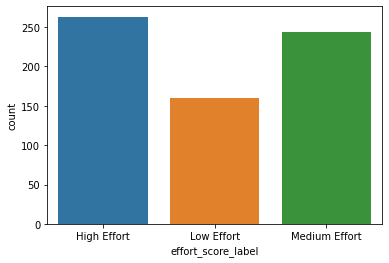

In [161]:
# checking workout type distribution
sns.countplot(score_df['effort_score_label']) # type: ignore
print(score_df['effort_score_label'].value_counts())

In [165]:
# Creating features df, this will only contain the scores for each column
feature_df = score_df.iloc[:,2:15]
feature_df

,distance_score,workout_time_score,calorie_score,total_elevation_gain_score,average_heartrate_score,max_heartrate_score,avg_time_per_lap_score,lap_count_score,avg_speed_score,max_speed_score,effort_score,effort_score_label
0,10,35,40,5,20,15,5,30,20,15,195,High Effort
1,1,25,35,1,20,30,5,30,1,5,153,High Effort
2,1,10,15,1,20,30,5,10,1,5,98,Low Effort
3,1,15,25,1,20,25,1,25,1,5,119,Low Effort
4,1,10,15,1,10,15,10,5,1,5,73,Low Effort
...,...,...,...,...,...,...,...,...,...,...,...,...
662,5,20,35,5,5,5,15,5,20,20,135,Medium Effort
663,15,30,5,5,5,5,20,5,35,30,155,High Effort
664,5,30,40,5,5,5,20,5,20,20,155,High Effort
665,5,25,35,5,5,5,20,5,15,20,140,Medium Effort


In [200]:
feature_df.to_csv(r'C:\Users\Manuel Elizaldi\Desktop\Learning-Testing\PyStrava\Outputs\test.csv')

In [219]:
# data prep for model 
# X -> Features, y -> labels
X = feature_df.iloc[:,0:11]
y = feature_df.iloc[:,11]

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [147]:
# Feature scaling - sets numbers to a similar range
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

array([[-0.39289149, -0.49366862,  0.03273366, ..., -0.3077317 ,
        -0.43437468, -0.22168579],
       [-0.39289149, -1.9041504 ,  0.3982595 , ..., -0.3077317 ,
        -0.43437468, -0.59550158],
       [-0.39289149, -0.49366862,  0.03273366, ..., -0.3077317 ,
        -0.43437468, -0.22168579],
       ...,
       [ 0.23386398,  1.62205404,  0.03273366, ..., -0.4767319 ,
         3.664654  ,  0.80007739],
       [-0.39289149, -0.14104818,  0.03273366, ..., -0.3077317 ,
        -0.43437468, -0.22168579],
       [-0.39289149, -1.9041504 ,  0.3982595 , ..., -0.3077317 ,
        -0.43437468, -0.72010685]])

In [150]:
# determining best k, aim for an odd number 
math.sqrt(len(y_train))

23.08679276123039

In [153]:
# training a KNN classifier
classifier = KNeighborsClassifier(n_neighbors = 23, p = 3, metric='euclidean').fit(X_train, y_train)

# predict the test set results
y_pred = classifier.predict(X_test)
y_pred

array([2, 2, 2, 2, 3, 3, 2, 2, 1, 3, 2, 3, 3, 2, 1, 2, 3, 1, 2, 2, 2, 2,
       3, 2, 3, 3, 1, 3, 3, 2, 3, 1, 2, 2, 3, 1, 1, 2, 1, 1, 2, 3, 3, 2,
       1, 2, 2, 1, 1, 2, 2, 3, 2, 3, 3, 2, 1, 3, 1, 2, 1, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 2, 3, 3, 2, 1, 3,
       3, 1, 1, 2, 1, 3, 1, 2, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 1,
       3, 2, 3, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2, 1, 3, 3, 3, 3, 3, 3, 2, 3,
       2, 2])

In [190]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
rmse

0.36650833306891567

[Text(0, 0.5, 'Low Effort'),
 Text(0, 1.5, 'Medium Effort'),
 Text(0, 2.5, 'High Effort')]

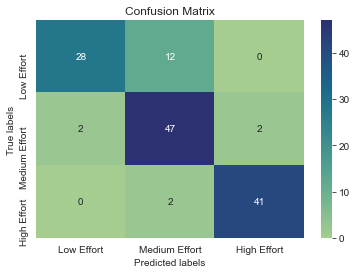

In [186]:
# Evaluating model
cm = confusion_matrix(y_test, y_pred) 

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="crest")  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Low Effort', 'Medium Effort', 'High Effort']); ax.yaxis.set_ticklabels(['Low Effort', 'Medium Effort', 'High Effort'])

In [184]:
print('F1 score:', round(f1_score(y_test, y_pred, average = 'micro'),3)) # type: ignore
print('Accuracy of the model:', round(accuracy_score(y_test,y_pred),3))
print("Precision Score : ", round(precision_score(y_test, y_pred, pos_label='positive', average='micro'),3)) # type: ignore
print("Recall Score : ",round(recall_score(y_test, y_pred, pos_label='positive', average='micro'),3)) # type: ignore
print(classification_report(y_test, y_pred, target_names=score_values))

F1 score: 0.866
Accuracy of the model: 0.866
Precision Score :  0.866
Recall Score :  0.866
               precision    recall  f1-score   support

   Low Effort       0.93      0.70      0.80        40
Medium Effort       0.77      0.92      0.84        51
  High Effort       0.95      0.95      0.95        43

     accuracy                           0.87       134
    macro avg       0.89      0.86      0.86       134
 weighted avg       0.88      0.87      0.86       134



c:\Users\Manuel Elizaldi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
